## Setup

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd
import seaborn as sns

In [2]:
# Modified from code provided by Kento Nozawa, University of Tokyo

# from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.preprocessing import sequence
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# Scalable Vector Graphics
from IPython.display import SVG, HTML
from IPython.display import Image

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
np.random.seed(13)

In [3]:
from sklearn.model_selection import train_test_split
import statistics
import math

from sklearn.metrics.pairwise import cosine_similarity

### Download the Data

In [4]:
# Some collected plays by Anton Chekhov
# url = "https://www.dropbox.com/s/6iywkifab9yfz1l/SentenceQualitySlim.csv?dl=1"
dataset = pd.read_csv("ScaleDataCollectionShared.csv")
dataset.head()

,EntryNum1,FirstAuthLastName2,Year3,NumCites4,DatePulled5,Dbsource6,FullCite7,ScaleTitle8,CronAlpha9,NumItems10,...,FirstValidation12,ItemTexts13,ScalePoints14,Instructions15,Notes16,jif17,Category18,EgoStatements19,Unnamed: 19,Unnamed: 20
0,1,Soldatos,2000,948,1/27/2021,Google Scholar,"Soldatos, C. R., Dikeos, D. G., & Paparrigopou...",Athens Insomnia Scale,0.89,8.0,...,FALSE,Sleep induction (time it takes you to fall asl...,4.0,This scale is intended to record your own asse...,NaN,2.41,Biomedical,False,NaN,NaN
1,2,Cardon,2013,522,2/22/2021,Google Scholar,"Melissa S. Cardon, Denis A. Gregoire, Christop...",EP for Inventing,0.85,5.0,...,TRUE,It is exciting to figure out new ways to solve...,5.0,Please indicate the extent to which you agree ...,NaN,7.59,Business,True,NaN,NaN
2,3,Cardon,2013,522,2/22/2021,Google Scholar,"Melissa S. Cardon, Denis A. Gregoire, Christop...",EP for Founding,0.72,4.0,...,TRUE,Establishing a new company excites me.; Owning...,5.0,Please indicate the extent to which you agree ...,NaN,7.59,Business,True,NaN,NaN
3,4,Cardon,2013,522,2/22/2021,Google Scholar,"Melissa S. Cardon, Denis A. Gregoire, Christop...",EP for Developing,0.77,4.0,...,TRUE,I really like finding the right people to mark...,5.0,Please indicate the extent to which you agree ...,NaN,7.59,Business,True,NaN,NaN
4,5,Snyder,1996,2227,1/18/2021,Google Scholar,"Snyder, C. R., Sympson, S. C., Ybasco, F. C., ...",State Hope Scale,0.93,6.0,...,TRUE,"If I should find myself in a jam, I could thin...",8.0,Directions: Read each item carefully. Using th...,NaN,5.91,Psychology,True,NaN,NaN


### Cleaning the dataset

In [5]:
# Remove null values in our X and Y variable columns
dataset = dataset[dataset['ItemTexts13'].isnull()==False][dataset['CronAlpha9'].isnull()==False]
dataset.shape

C:\Users\Kathik\AppData\Local\Temp/ipykernel_6984/3804334506.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[dataset['ItemTexts13'].isnull()==False][dataset['CronAlpha9'].isnull()==False]


(310, 21)

In [6]:
# save all input sentences in a variable
sentences = dataset['ItemTexts13']
sentences

0      Sleep induction (time it takes you to fall asl...
1      It is exciting to figure out new ways to solve...
2      Establishing a new company excites me.; Owning...
3      I really like finding the right people to mark...
4      If I should find myself in a jam, I could thin...
                             ...                        
319    I consider myself an athlete.; I have many goa...
323    I think in detail about costs and benefits.; I...
324    I trust my gut instinct.I trust my feelings.; ...
325    I ask friends to give me advice.; I think of s...
326    I rely on spiritual discernment.; I use spirit...
Name: ItemTexts13, Length: 310, dtype: object

In [7]:
def clean_str(string):
    """
    String clean up reg exes.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    # return lowercase version of entire sentence
    # and remove all leading spaces
    return string.strip().lower()

In [8]:
# Apply the clean_str function to our sentences
cleaned_sentences = []
for sentence in dataset["ItemTexts13"]:
    cleaned_sentences.append(clean_str(sentence.strip()))

In [9]:
# Sentence Before Cleaning
dataset.ItemTexts13[0]

'Sleep induction (time it takes you to fall asleep after turning-off the lights); Awakenings during the night; Final awakening earlier than desired; Total sleep duration; Overall quality of sleep (no matter how long you slept); Sense of well-being during the day; Functioning (physical and mental) during the day; Sleepiness during the day'

In [10]:
# Sentence After Cleaning
cleaned_sentences[0]

'sleep induction \\( time it takes you to fall asleep after turning off the lights \\) awakenings during the night final awakening earlier than desired total sleep duration overall quality of sleep \\( no matter how long you slept \\) sense of well being during the day functioning \\( physical and mental \\) during the day sleepiness during the day'

In [11]:
# Max sentence length
# used to determine the size of our input X matrix
max_sentence_length = max([len(sentence.split(" ")) for sentence in cleaned_sentences])
max_sentence_length

766

In [12]:
# Break each sentence into words on the basis of " " (space) token
# to get a list of words used in our sentences
tokens = [t for doc in cleaned_sentences for t in doc.split(" ")]

# length of list gives us vocabulary size
vocab_size = len(tokens)
vocab_size

28479

In [13]:
# Create a dictionary of words with their respective frequency
counter = Counter(tokens)

# Find unique tokens which are the keys of the dictionary
index2word = list(counter.keys())

# insert padding string
# this string will be used to pad the sentences which are shorter than
# the max length to create a matrix without empty cells
index2word.insert(0, 'PAD')

# vocabulary size with padding
len(index2word)

2977

In [14]:
# Initialize Token ID Matrix with shape
# Number of Sentences vs maximum sentence size
x_matrix = np.full((len(cleaned_sentences), max_sentence_length), 0)

# loop through all the sentences
for i, sequence in enumerate(cleaned_sentences):
    # each row is the collection of the index within our vocabulary
    # for each word in the sentences 
    row_ix = [index2word.index(w) for w in sequence.split(' ')]
    # assign the list of index to the respective row in our input matrix
    x_matrix[i, :len(row_ix)] = row_ix

# check shape of matrix
x_matrix.shape

(310, 766)

### Download GloVe Embeddings

In [15]:
embedding_width = 300

In [16]:
print("Loading word embeddings...")
embeddings_index = dict() # Initialize an empty dictionary
embedding_dir = 'glove.6B.'+str(embedding_width)+'d.txt'   # Set filename with word embeddings

f = open(embedding_dir,encoding="utf8")   # open embeddings file
for line in f:  # loop through all the row entries in the file
    values = line.split()   # split each row at a space
    word = values[0]   # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32')  # the numbers from the second entry are the embeddings. Convert them to an array of floating point values
    embeddings_index[word] = coefs   # add them to a dictionary 
f.close()   # close the file
print('Loaded %s word vectors.' % len(embeddings_index))   # give notification that loading is complete

Loading word embeddings...
Loaded 400001 word vectors.


In [17]:
# Check size of word embeddings
embeddings_index.get('-').shape

(300,)

### Generating the Word Embedding Weight Matrix for words in training 

In [18]:
# create a weight matrix for words in training docs
# it is a mtrix of each word in our vocabulary and their respective word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_width))

# loop through all the words in our vocabulary
for i, word in enumerate(index2word):
    # retrieve word embedding for the respective word 
    embedding_vector = embeddings_index.get(word)
    
    # if word embedding is available then add it to our matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:  # otherwise give a prompt that the embedding is not available
        print(word," is not available")

PAD  is not available
\(  is not available
\)  is not available
\?  is not available
nowdays  is not available
ignorning  is not available
culty  is not available
employees'  is not available
openrice  is not available
udoo  is not available
codu  is not available


In [19]:
# Shape of the matrix: (Number of words, size of word embedding)
embedding_matrix.shape

(28479, 300)

# The Model

In [20]:
# The Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_width, weights = [embedding_matrix] , trainable = False, input_length=max_sentence_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))

# Adam optimizer
adam_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam')
model.compile(loss='mse',
              optimizer=adam_opt,
              metrics=['mse','mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 766, 300)          8543700   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,637,205
Trainable params: 93,505
Non-trainable params: 8,543,700
_________________________________________________________________


In [21]:
# Set number of epochs for which the model needs to be trained
nb_epoch = 5

#### Some functions for training

In [23]:
def train_model_on_dataset(X, y, model, nb_epoch):
    # create training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, shuffle=False)
    # train the model on the training data and then return the results
    training_results = model.fit(X_train, y_train, batch_size=8, epochs=nb_epoch, validation_data=(X_test, y_test))
    return training_results

In [24]:
def create_error_plots(mse_history, mae_history, nb_epoch):
    x = range(nb_epoch)   # set range of x axis to the number of epochs
    
    # plot the Mean Square Error vs the epochs
    plt.plot(x, mse_history, label="Mean Square Error")
    plt.title("Training Loss: MSE")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    # plot the Mean Absolute Error vs the epochs
    plt.plot(x, mae_history, label="Mean Absolute Error")
    plt.title("Training Loss: MAE")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [25]:
def kfold_multiple_trains(x_matrix, y, model, nb_epoch, vocab_size, embedding_width, max_sentence_length, embedding_matrix):
    # create variables for the outputs of the k-fold models
    model_dict, mse_history, mae_history = {}, [], []
    
    # loop through the number of k-folds, which is the length of the input divided by 50
    for index in range(0, len(y), 50):
        # Create the 'index' iteration of the k-fold dataset
        X_test = x_matrix[index:index+50]
        X_train = np.concatenate((x_matrix[0:index],x_matrix[index+50:]), axis=0)
        y_test = y[index:index+50]
        y_train = np.concatenate((y[0:index],y[index+50:]),axis=0)
        
        # The Model for the 'index' iteration of the k-fold dataset
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_width, input_length =max_sentence_length, weights = [embedding_matrix] , trainable = False))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(1, activation="linear"))
        
        # Adam optimizer
        adam_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
            name='Adam')
        model.compile(loss='mse',
                      optimizer=adam_opt,
                      metrics=['mse','mae'])
        model.summary()
        
        # Train the model for the 'index' iteration of the k-fold dataset
        train_results = model.fit(X_train, y_train, batch_size=8, epochs=nb_epoch,
                   validation_data=(X_test, y_test))
        
        # make cronbach alpha predictions using the model
        y_pred = model.predict(X_test)
        # calculate the accuracy using the r_squared metric
        r_squared = get_rsquared_for_model(y_test, y_pred).numpy()
        
        # update output variables
        model_dict[index] = [model, train_results, y_pred, r_squared]
        mse_history.append(train_results.history['mse'])
        mae_history.append(train_results.history['mae'])
    
    return model_dict, mse_history, mae_history

In [26]:
# plot error metrics vs k-folds graphs
def plot_k_fold_final_errors(variable, mse_list, mae_list):
    x = range(1,len(mse_list)+1)
    plt.plot(x, mse_list, label="Mean Square Error")

    plt.title(variable+" MSE per n-fold run")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(x, mae_list, label="Mean Absolute Error")
    plt.title(variable+" MAE per n-fold run")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [27]:
# Calculate R squared for the model
def get_rsquared_for_model(y, y_pred):
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    R_squared = tf.subtract(1, tf.divide(unexplained_error, total_error))
    return R_squared

# Predict Cronbach's Alpha

This model attempts to predict the original Cronbach's Aplha values from our sentences as inputs.

In [28]:
y_cron = dataset['CronAlpha9'].apply(float)
y_cron

0      0.89
1      0.85
2      0.72
3      0.77
4      0.93
       ... 
319    0.81
323    0.78
324    0.83
325    0.84
326    0.94
Name: CronAlpha9, Length: 310, dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_matrix, y_cron, test_size=0.20, random_state=200, shuffle=False)

# The Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_width, input_length =max_sentence_length, weights = [embedding_matrix] , trainable = False))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))

# Adam optimizer
adam_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam')
model.compile(loss='mse',
              optimizer=adam_opt,
              metrics=['mse','mae'])
model.summary()

# Train the model
train_results = model.fit(X_train, y_train, batch_size=10, epochs=5,
           validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 766, 300)          8543700   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,637,205
Trainable params: 93,505
Non-trainable params: 8,543,700
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 7s 219ms/step - loss: 2.3531 - mse: 2.3531 - mae: 0.9288 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1828
Epoch 2/5
25/25 [==============================] - 5s 220ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0910 - val_loss: 0.0063 - val_mse: 0.

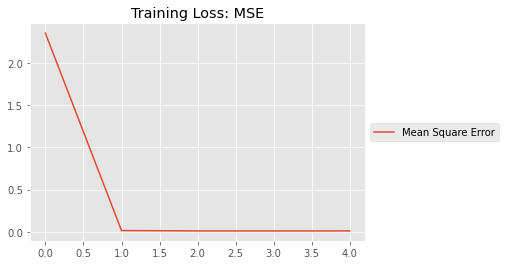

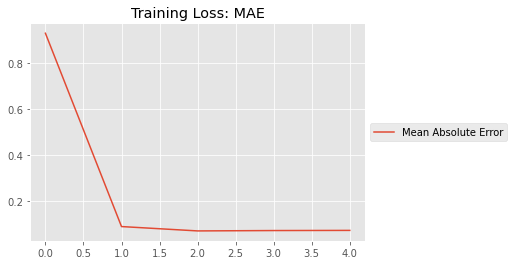

In [30]:
create_error_plots(train_results.history['mse'], train_results.history['mae'], nb_epoch=5)

In [32]:
y_pred = model.predict(X_test)
y_pred

array([[0.83963656],
       [0.8396365 ],
       [0.83963656],
       [0.8396365 ],
       [0.8396366 ],
       [0.8396365 ],
       [0.83963656],
       [0.8396365 ],
       [0.83963656],
       [0.8396365 ],
       [0.8396366 ],
       [0.83963656],
       [0.83963656],
       [0.8396365 ],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.8396365 ],
       [0.83963656],
       [0.8396366 ],
       [0.8396365 ],
       [0.8396366 ],
       [0.8396366 ],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.8396365 ],
       [0.8396366 ],
       [0.8396365 ],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.8396366 ],
       [0.83963656],
       [0.8396366 ],
       [0.83963656],
       [0.8396365 ],
       [0.8396366 ],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.8396365 ],
       [0.83963656],
       [0.83963656],
       [0.83963656],
       [0.839

In [39]:
# Get R-Squared for the model
print(float(get_rsquared_for_model(y_cron, y_pred)))

-63.36852778647636


<AxesSubplot:xlabel='CronAlpha9', ylabel='Count'>

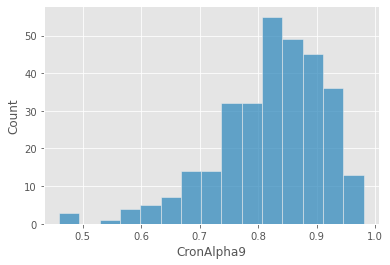

In [33]:
sns.histplot(y_cron)

In [34]:
print("Mean Cronbach's Alpha:", str(statistics.mean(y_cron)))
print("Median Cronbach's Alpha:", str(statistics.median(y_cron)))
print("Mode Cronbach's Alpha:", str(statistics.mode(y_cron)))

Mean Cronbach's Alpha: 0.8214209677419355
Median Cronbach's Alpha: 0.835
Mode Cronbach's Alpha: 0.81


#### OBSERVATIONS
- The error plots show that the model is trained to minimze the prediction error and does that very effectively
- However, the R-Squared value is negative which is not correct. I have rechecked the function and there appears to be no error in the calculation methodology.
- Looking at the y_pred, we see that the model is predicting a value close to the Median of the y_cron variable. By doing that it is able to minimize the error significantly but not give us accurate predictions

#### INFERENCES AND WAY FORWARD
The above observations show that the range of y_cron is narrow. This has resulted in a model which has too much bias and too little variance. Going forward we can:
- attempt to increase the range by predicting the z score of each cronbach's alpha within the distribution of the variable y_cron.
- change this to a classification problem by using the sentences to predict the integeral z-scores
- use sentence embeddings to predict the cosine similarity between sub-sentences in each input sentence. We can then use these cosine similarities to predict the cronbach's alpha using a simple feed forward neural network.

In [45]:
# Some related reading
#LINK: https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean

# Predict number of Standard Deviations from Mean

In [41]:
mean_cron = statistics.mean(y_cron)
stdev_cron = statistics.stdev(y_cron)
print("Mean Cronbach's Alpha:", mean_cron)
print("Standard Deviation for Cronbach's Alpha:", stdev_cron)

Mean Cronbach's Alpha: 0.8214209677419355
Standard Deviation for Cronbach's Alpha: 0.0928623457313236


In [42]:
z_cron = ((y_cron-mean_cron)/stdev_cron)
z_cron

0      0.738502
1      0.307757
2     -1.092165
3     -0.553733
4      1.169247
         ...   
319   -0.122988
323   -0.446047
324    0.092384
325    0.200071
326    1.276933
Name: CronAlpha9, Length: 310, dtype: float64

In [50]:
print("Range for Cronbach's Alpha")
print("Min:",min(y_cron),"Max:", max(y_cron))

Range for Cronbach's Alpha
Min: 0.46 Max: 0.98


In [51]:
print("Range for Z Scores of Cronbach's Alpha")
print("Min:",min(z_cron),"Max:", max(z_cron))

Range for Z Scores of Cronbach's Alpha
Min: -3.8920077335503254 Max: 1.7076785106945003


<AxesSubplot:xlabel='CronAlpha9', ylabel='Count'>

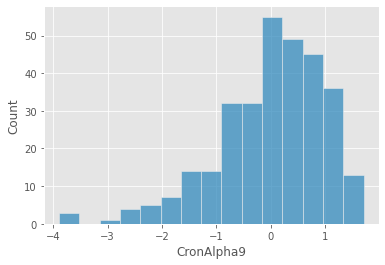

In [52]:
sns.histplot(z_cron)

From the above range we can see that we have managed to increase the variation in the y values for our model. Let us now attempt to predict the Z Scores using our sentences as input.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_matrix, z_cron, test_size=0.20, random_state=200, shuffle=False)

# The Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_width, input_length =max_sentence_length, weights = [embedding_matrix] , trainable = False))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))

# Adam optimizer
adam_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam')
model.compile(loss='mse',
              optimizer=adam_opt,
              metrics=['mse','mae'])
model.summary()

# Train the model
train_results = model.fit(X_train, y_train, batch_size=10, epochs=5,
           validation_data=(X_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 766, 300)          8543700   
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,637,205
Trainable params: 93,505
Non-trainable params: 8,543,700
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 7s 216ms/step - loss: 1.1066 - mse: 1.1066 - mae: 0.8119 - val_loss: 0.8911 - val_mse: 0.8911 - val_mae: 0.7737
Epoch 2/5
25/25 [==============================] - 5s 216ms/step - loss: 1.0494 - mse: 1.0494 - mae: 0.7861 - val_loss: 0.9096 - val_mse: 0.

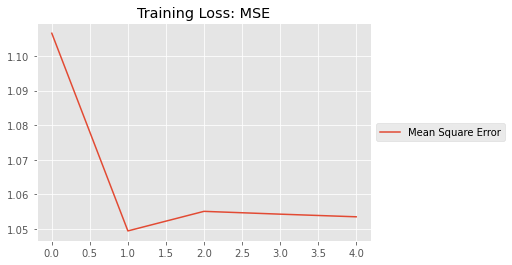

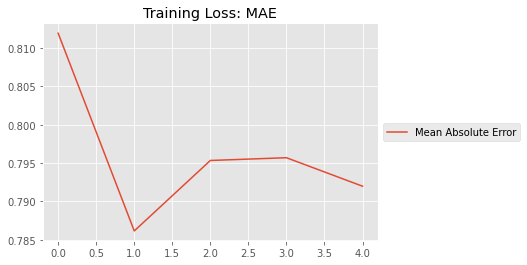

In [54]:
create_error_plots(train_results.history['mse'], train_results.history['mae'], nb_epoch=5)

In [55]:
y_pred = model.predict(X_test)
y_pred

array([[-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0.11606007],
       [-0

In [56]:
# Get R-Squared for the model
print(float(get_rsquared_for_model(z_cron, y_pred)))

-61.840060100756645


In [57]:
print("Mean Cronbach's Alpha Z Score:", str(statistics.mean(z_cron)))
print("Median Cronbach's Alpha Z Score:", str(statistics.median(z_cron)))
print("Mode Cronbach's Alpha Z Score:", str(statistics.mode(z_cron)))

Mean Cronbach's Alpha Z Score: -3.126251497819235e-16
Median Cronbach's Alpha Z Score: 0.14622753874161587
Mode Cronbach's Alpha Z Score: -0.12298814607784596


#### OBSERVATIONS AND INFERENCES
The previous issue of the model predicting a value close to the median of the original output variables persists. So the increase in the variance of the output variable by using z scores did not have the intended effect.

# Convert to classification problem

In [58]:
cron_classification = pd.DataFrame({'z':(y_cron-mean_cron)/stdev_cron})
mean_z = statistics.mean(z_cron)
stdev_z = statistics.stdev(z_cron)

class_column = []
for row in list(cron_classification.index):
    if cron_classification.loc[row,'z']<=mean_z+stdev_z and cron_classification.loc[row,'z']>=mean_z-stdev_z:
        class_column.append(0)
    elif cron_classification.loc[row,'z']>mean_z+stdev_z:
        class_column.append(1)
    elif cron_classification.loc[row,'z']<mean_z-stdev_z and cron_classification.loc[row,'z']>=mean_z-(2*stdev_z):
        class_column.append(2)
    else:
        class_column.append(3)

cron_classification['Class'] = class_column
cron_classification

,z,Class
0,0.738502,0
1,0.307757,0
2,-1.092165,2
3,-0.553733,0
4,1.169247,1
...,...,...
319,-0.122988,0
323,-0.446047,0
324,0.092384,0
325,0.200071,0


<AxesSubplot:xlabel='Class', ylabel='Count'>

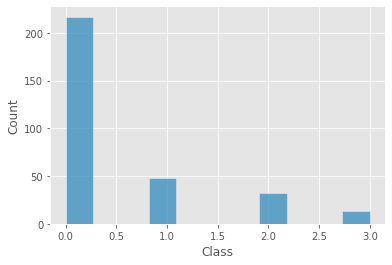

In [59]:
sns.histplot(cron_classification['Class'])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(x_matrix, cron_classification['Class'], test_size=0.20, random_state=200, shuffle=False)

# The Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_width, input_length =max_sentence_length, weights = [embedding_matrix] , trainable = False))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(4, activation="softmax"))

# Adam optimizer
adam_opt = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam')
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])
model.summary()

# Train the model
train_results = model.fit(X_train, y_train, batch_size=10, epochs=5,
           validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 766, 300)          8543700   
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8,637,400
Trainable params: 93,700
Non-trainable params: 8,543,700
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 7s 222ms/step - loss: 1.2585 - accuracy: 0.5927 - val_loss: 0.8574 - val_accuracy: 0.6935
Epoch 2/5
25/25 [==============================] - 5s 205ms/step - loss: 1.0529 - accuracy: 0.7016 - val_loss: 0.9365 - val_accuracy: 0.6935
Epoch 3/5
25/25 [====

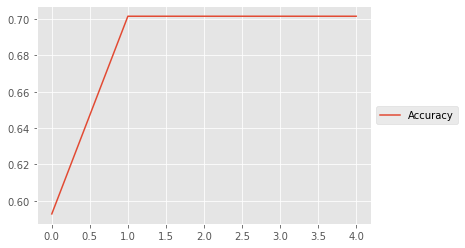

In [61]:
x = range(nb_epoch)
plt.plot(x, train_results.history['accuracy'], label="Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [62]:
train_predictions = model.predict(X_train)

predicted_class_train = []
for row in train_predictions:
    predicted_class_train.append(np.argmax(row))

In [63]:
from sklearn.metrics import confusion_matrix,accuracy_score

confusion_matrix(y_train, predicted_class_train)

array([[174,   0,   0,   0],
       [ 33,   0,   0,   0],
       [ 29,   0,   0,   0],
       [ 12,   0,   0,   0]], dtype=int64)

In [64]:
print("The accuracy over training set: ",str(accuracy_score(y_train,predicted_class_train)))

The accuracy over training set:  0.7016129032258065


In [66]:
y_pred = model.predict(X_test)
y_pred

array([[0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452536, 0.05077237],
       [0.69083095, 0.14387138, 0.11452537, 0.05077237],
       [0.69083095, 0.14387138,

In [69]:
test_predictions = model.predict(X_test)

predicted_class_test = []
for row in test_predictions:
    predicted_class_test.append(np.argmax(row))

print("The accuracy over testing set: ",str(accuracy_score(y_test, predicted_class_test)))

The accuracy over testing set:  0.6935483870967742


#### OBSERVATIONS AND INFERENCES
The previous issue of the model predicting a value close to the median of the original output variables persists. So the increase in the variance of the output variable by using z scores did not have the intended effect.

# Using Sentence Transformers

In [70]:
# Import sentence transformers model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [71]:
sentences

0      Sleep induction (time it takes you to fall asl...
1      It is exciting to figure out new ways to solve...
2      Establishing a new company excites me.; Owning...
3      I really like finding the right people to mark...
4      If I should find myself in a jam, I could thin...
                             ...                        
319    I consider myself an athlete.; I have many goa...
323    I think in detail about costs and benefits.; I...
324    I trust my gut instinct.I trust my feelings.; ...
325    I ask friends to give me advice.; I think of s...
326    I rely on spiritual discernment.; I use spirit...
Name: ItemTexts13, Length: 310, dtype: object

In [72]:
sentences_list = []

for sentence in list(sentences):
    sentences_list.append(sentence.split(";"))

In [73]:
encoded_sentences = []

for sentence in list(sentences):
    encoded_sentences.append(model.encode(sentence.split(";")))

##### Some diagnosis to check encodings

check if the length of both variables is equal

In [74]:
len(sentences)

310

In [75]:
len(encoded_sentences)

310

Check if each of the sub sentences in the first input is broken down and represented as a sentence transformer

In [76]:
encoded_sentences[0].shape

(8, 768)

In [77]:
for i in range(len(sentences_list[0])):
    print(sentences_list[0][i], len(sentences_list[0][i]))

Sleep induction (time it takes you to fall asleep after turning-off the lights) 79
 Awakenings during the night 28
 Final awakening earlier than desired 37
 Total sleep duration 21
 Overall quality of sleep (no matter how long you slept) 56
 Sense of well-being during the day 35
 Functioning (physical and mental) during the day 49
 Sleepiness during the day 26


In [78]:
for i in range(len(sentences_list[0])):
    print(len(sentences_list[0][i]), (model.encode(sentences_list[0][5])).shape)

79 (768,)
28 (768,)
37 (768,)
21 (768,)
56 (768,)
35 (768,)
49 (768,)
26 (768,)


##### Create cosine similarity matrix

In [79]:
# find maximum number of sentences among all the inputs
max_sentence_count = max([len(sentence.split(";")) for sentence in sentences])
max_sentence_count

55

In [80]:
# create an array of zeroes with the number of inputs as number of rows
# and maximum number of sentences among all the inputs as the columns
cos_dist_matrix = np.zeros((len(encoded_sentences),max_sentence_count))
cos_dist_matrix.shape

(310, 55)

In [81]:
# test cosine_similarity function
cosine_similarity(encoded_sentences[0][0].reshape(-1, 1),encoded_sentences[1][4].reshape(-1, 1))[0][0]

-1.0

In [82]:
# populate the cosine similarity matrix
for row in range(len(encoded_sentences)):
    for column in range(len(encoded_sentences[row])-1):
        cos_dist_matrix[row, column] = cosine_similarity(encoded_sentences[row][column].reshape(-1, 1),encoded_sentences[row][column+1].reshape(-1, 1))[0][0]

In [83]:
cos_dist_matrix[5]

array([ 1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

##### Model for Cronbach Alpha Prediction

In [84]:
X = cos_dist_matrix
y = dataset['CronAlpha9'].apply(float)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=200, shuffle=False)

In [86]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

###### 100 epochs

In [97]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               7168      
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 172,033
Trainable params: 172,033
Non-trainable params: 0
_________________________________________________________________


In [98]:
history_100 = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2)

Epoch 1/100
7/7 [==============================] - 1s 36ms/step - loss: 0.6502 - mean_absolute_error: 0.6502 - val_loss: 0.2336 - val_mean_absolute_error: 0.2336
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.2388 - mean_absolute_error: 0.2388 - val_loss: 0.2365 - val_mean_absolute_error: 0.2365
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2171 - mean_absolute_error: 0.2171 - val_loss: 0.1521 - val_mean_absolute_error: 0.1521
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1498 - mean_absolute_error: 0.1498 - val_loss: 0.1282 - val_mean_absolute_error: 0.1282
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1136 - mean_absolute_error: 0.1136 - val_loss: 0.0992 - val_mean_absolute_error: 0.0992
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0947 - mean_absolute_error: 0.0947 - val_loss: 0.0970 - val_mean_absolute_error: 0.0970
Epoch 7/100
7/7 [===========

7/7 [==============================] - 0s 10ms/step - loss: 0.0508 - mean_absolute_error: 0.0508 - val_loss: 0.0809 - val_mean_absolute_error: 0.0809
Epoch 52/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0529 - mean_absolute_error: 0.0529 - val_loss: 0.0774 - val_mean_absolute_error: 0.0774
Epoch 53/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0501 - mean_absolute_error: 0.0501 - val_loss: 0.0766 - val_mean_absolute_error: 0.0766
Epoch 54/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 55/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0695 - mean_absolute_error: 0.0695 - val_loss: 0.0808 - val_mean_absolute_error: 0.0808
Epoch 56/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0583 - mean_absolute_error: 0.0583 - val_loss: 0.0779 - val_mean_absolute_error: 0.0779
Epoch 57/100
7/7 [=================

In [99]:
def get_plots(history):
    # summarize history for accuracy
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model error')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

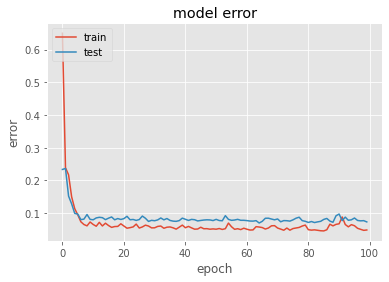

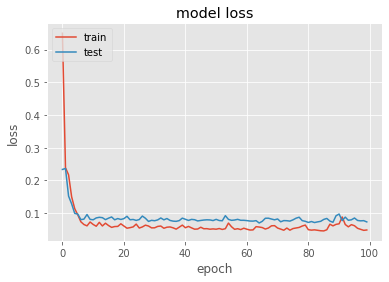

In [100]:
get_plots(history_100)

In [101]:
predictions = NN_model.predict(X_test)
predictions

array([[0.73028773],
       [0.82367736],
       [1.0150186 ],
       [0.7986601 ],
       [0.8381619 ],
       [0.75116855],
       [0.7771673 ],
       [0.81927645],
       [0.8721728 ],
       [0.8254861 ],
       [0.8254861 ],
       [0.8026987 ],
       [0.8254861 ],
       [0.8824219 ],
       [0.75116855],
       [0.8381619 ],
       [0.78510445],
       [0.75116855],
       [0.8026862 ],
       [0.75116855],
       [0.75116855],
       [0.75116855],
       [0.75116855],
       [0.79755944],
       [0.7771673 ],
       [0.75116855],
       [0.7771673 ],
       [0.79755944],
       [0.84942603],
       [0.8480164 ],
       [0.8026862 ],
       [0.75116855],
       [0.9257961 ],
       [0.9523894 ],
       [0.76878554],
       [1.1612854 ],
       [0.82232386],
       [0.99046093],
       [0.81287485],
       [1.0523889 ],
       [0.88755435],
       [0.8075148 ],
       [0.80209243],
       [0.81927645],
       [0.9744242 ],
       [0.8711441 ],
       [0.8379746 ],
       [0.896

We can see that the predictions are not centered at a single value and this is an improvement from the previous models.

###### 150 epochs

In [104]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               7168      
                                                                 
 dense_20 (Dense)            (None, 256)               33024     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 172,033
Trainable params: 172,033
Non-trainable params: 0
_________________________________________________________________


In [105]:
history_150 = NN_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split = 0.2)

Epoch 1/150
7/7 [==============================] - 1s 49ms/step - loss: 0.6292 - mean_absolute_error: 0.6292 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935
Epoch 2/150
7/7 [==============================] - 0s 15ms/step - loss: 0.2240 - mean_absolute_error: 0.2240 - val_loss: 0.2241 - val_mean_absolute_error: 0.2241
Epoch 3/150
7/7 [==============================] - 0s 14ms/step - loss: 0.2109 - mean_absolute_error: 0.2109 - val_loss: 0.1234 - val_mean_absolute_error: 0.1234
Epoch 4/150
7/7 [==============================] - 0s 12ms/step - loss: 0.1507 - mean_absolute_error: 0.1507 - val_loss: 0.1529 - val_mean_absolute_error: 0.1529
Epoch 5/150
7/7 [==============================] - 0s 15ms/step - loss: 0.1292 - mean_absolute_error: 0.1292 - val_loss: 0.1046 - val_mean_absolute_error: 0.1046
Epoch 6/150
7/7 [==============================] - 0s 12ms/step - loss: 0.1161 - mean_absolute_error: 0.1161 - val_loss: 0.1250 - val_mean_absolute_error: 0.1250
Epoch 7/150
7/7 [===========

7/7 [==============================] - 0s 13ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - val_loss: 0.0738 - val_mean_absolute_error: 0.0738
Epoch 52/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797
Epoch 53/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0752 - val_mean_absolute_error: 0.0752
Epoch 54/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0758 - val_mean_absolute_error: 0.0758
Epoch 55/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0484 - mean_absolute_error: 0.0484 - val_loss: 0.0758 - val_mean_absolute_error: 0.0758
Epoch 56/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0752 - val_mean_absolute_error: 0.0752
Epoch 57/150
7/7 [=================

7/7 [==============================] - 0s 8ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0735 - val_mean_absolute_error: 0.0735
Epoch 102/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0467 - mean_absolute_error: 0.0467 - val_loss: 0.0767 - val_mean_absolute_error: 0.0767
Epoch 103/150
7/7 [==============================] - 0s 9ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0721 - val_mean_absolute_error: 0.0721
Epoch 104/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - val_loss: 0.0766 - val_mean_absolute_error: 0.0766
Epoch 105/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0808 - val_mean_absolute_error: 0.0808
Epoch 106/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0846 - val_mean_absolute_error: 0.0846
Epoch 107/150
7/7 [=================

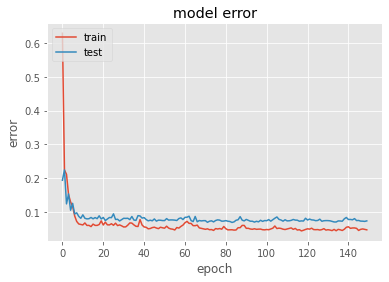

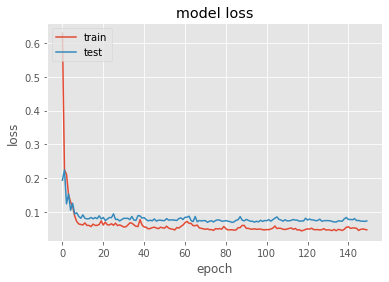

In [106]:
get_plots(history_150)

###### Predictions

In [107]:
predictions = NN_model.predict(X_test)

In [108]:
# error for 150 epoch model
mean_squared_error(y_test, predictions)

0.009387805868041882

In [109]:
prediction_df = pd.DataFrame(columns=['Original_Alpha','Predicted_Alpha'])
prediction_df['Original_Alpha'] = y
prediction_df['Predicted_Alpha'] = NN_model.predict(X)

In [110]:
prediction_df.to_excel("Alpha_Predictions_150.xlsx")